# Notebook created 17.02.2025


In [1]:
#imports to be used later on
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
from astropy.io import fits
import matplotlib
import scipy.ndimage
import scipy.interpolate
from astropy.table import Table
import astropy.units as u
%matplotlib inline

import math
import matplotlib.patches as patches

import random

# # gala
# import gala.coordinates as gc
# import gala.dynamics as gd
# import gala.potential as gp
# from gala.units import galactic
# import gala.integrate as gi
# from gala.units import galactic, UnitSystem

import astropy.coordinates as coord
from astropy.coordinates import SkyOffsetFrame 
from astropy.wcs import WCS
plt.ioff

from scipy.optimize import minimize

# import reproject

from scipy.interpolate import interp1d

# Default gala cosmology: # WMAP7 cosmology in effect
from astropy import cosmology
cosmo = cosmology.default_cosmology.get()


# # Import all the functions needed for fitting + stream generating etv
# import CenA_functions as CenA

In [2]:
path = '/Users/hzg129/Desktop/Research2024/CENA/'
plot_path = '/Users/spearson/Desktop/Research/CenA/CenA2021/plots/'

In [3]:
mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 22#label_size 
mpl.rcParams['ytick.labelsize'] =22 #label_size a

# Data 

In [4]:
#path = '/Users/spearson/Desktop/Research/CenA/'
hdulist = fits.open(path + 'CenA_rgbmap_msolpc2.fits')
hdulist.info()
hdulist[0].data
hdr = dict(hdulist[0].header)
image = hdulist[0].data
wcs_input_dict = hdulist[0].header
wcs_helix_dict = WCS(wcs_input_dict)
header = hdulist[0].header
wcs_helix = WCS(header)

#getting rid of 0's from image data for imshow lognorm to work
j = 0
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i,j] == 0.:
            image[i,j] = 10**-10
            j = j+1

# j = 0
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         if math.isnan(image[i,j]):
#             print('it is nan')
#             image[i,j] = 10**-10
#             j = j+1





Filename: /Users/hzg129/Desktop/Research2024/CENA/CenA_rgbmap_msolpc2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (456, 424)   float64   


In [5]:
# #Test for histogram for Fiona. 

In [6]:
#header

In [7]:
image_fill = np.ones([426,456])*10**-10

# Plot data

Text(401, 28, '30 kpc')

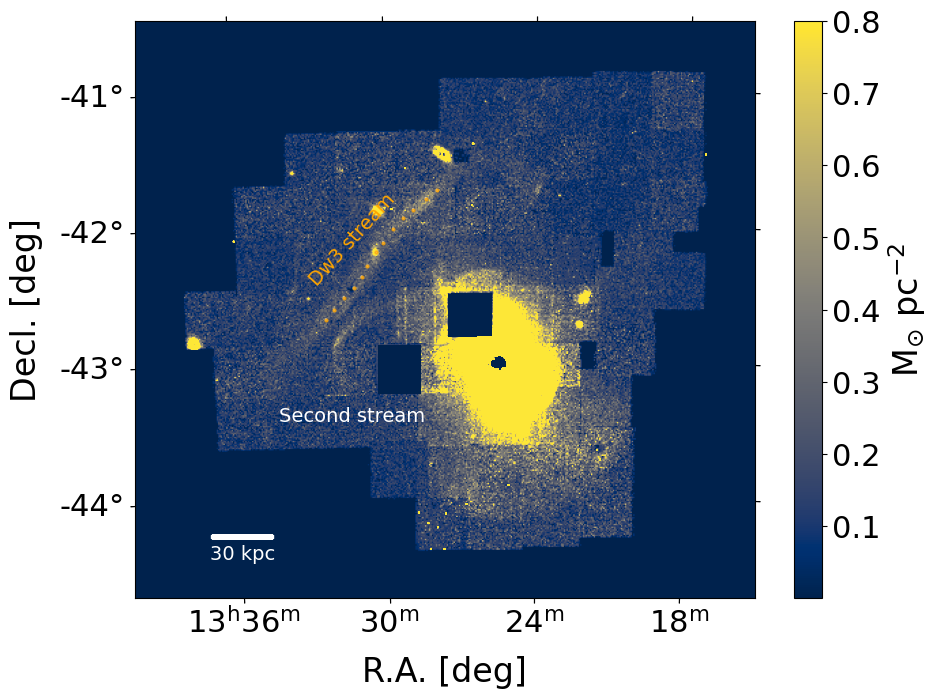

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs_helix)
#plt.imshow(image_fill, origin='lower', cmap='cividis', norm=LogNorm(),vmin =0.01, vmax = 10, aspect='equal', rasterized=True)
plt.imshow(image, origin='lower', cmap='cividis',  aspect='equal', rasterized=True,vmin =0.00001, vmax = 0.8)
plt.xlabel(r'R.A. [deg]')
plt.ylabel(r'Decl. [deg]')
plt.colorbar(label='M$_{\odot}$ pc$^{-2}$', shrink=0.75)



control_points_new = coord.SkyCoord([203.1,\
    202.585167, 202.675, 202.735,202.816, 202.916, 203.016, \
                                 202.515, 202.415, 202.315, 202.215, 202.09,\
                                    201.98]*u.deg, \
                                [-42.68,\
    -42.191741,-42.29,-42.37, -42.45,-42.52,-42.61, \
                                 -42.12, -42.02, -41.94,  -41.88, -41.8,\
                                 -41.74,]*u.deg)


ra_err_new =  np.ones(len(control_points_new.ra.deg))*0.01
dec_err_new =  np.ones(len(control_points_new.dec.deg))*0.01
plt.errorbar(control_points_new.ra.deg, control_points_new.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)

# plt.errorbar(control_SS.ra.deg, control_SS.dec.deg,yerr=0.01, xerr=None,\
#              fmt='.', color='white',markersize=4,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)




plt.text(350,130,'Second stream', rotation=0, size=14, color='white', rasterized=True)
plt.text(330,230,'Dw3 stream', rotation=47.76, size=14, color='orange', rasterized=True)

ax.set_ylim([0,424])
ax.set_xlim([456,0])

plt.fill_between([400,354],44,46, color='white', rasterized=True)
plt.text(401,28, '30 kpc', color='white', fontsize=14, rasterized=True)
    
#fig.tight_layout()
#fig.savefig(path + 'CenA2021/plots/Fig1_paper.pdf', dpi=300)


In [9]:
#Test for histogram for Fiona 

## Try changing your threshold and bin_factor to change spacing of the red points you will use as input to your data.

Changing the bin factor will also change the value in each pixel (try visualizing plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto'))

In [136]:
threshold = 0.45
binary_mask = np.where(image > threshold, 1, 0)

In [137]:
bin_factor = 4  # Change this to control bin size

y_size, x_size = binary_mask.shape
new_y, new_x = y_size // bin_factor, x_size // bin_factor


In [138]:
# Rebin the mask: sum over bin_factor × bin_factor regions
rebinned = binary_mask[:new_y * bin_factor, :new_x * bin_factor]  # Trim excess
rebinned = rebinned.reshape(new_y, bin_factor, new_x, bin_factor).sum(axis=(1, 3))

# Normalize to binary (1 if any value > 0 in bin)
rebinned_binary = np.where(rebinned > 0, 1, 0)

# Compute bin centers
x_centers = (np.arange(new_x) + 0.5) * bin_factor
y_centers = (np.arange(new_y) + 0.5) * bin_factor

# Find bin centers where rebinned_binary == 1
y_idx, x_idx = np.where(rebinned_binary == 1)
x_pts = x_centers[x_idx]
y_pts = y_centers[y_idx]



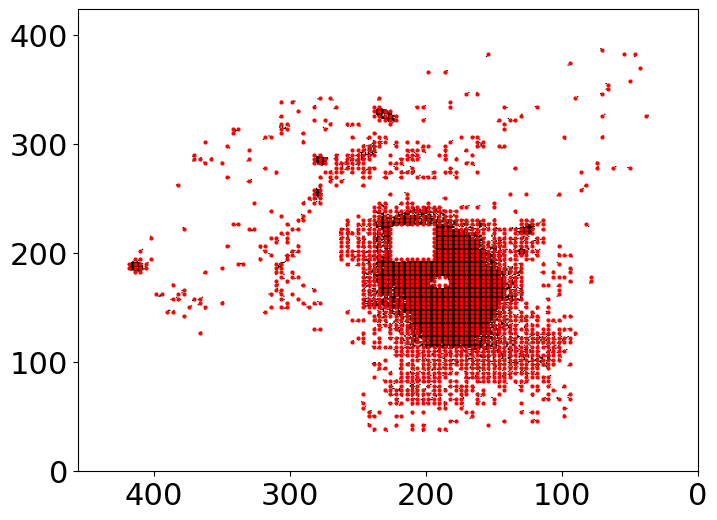

In [139]:
plt.figure(figsize=(8, 6))
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
#plt.imshow(rebinned_binary, origin='lower', cmap='binary', aspect='auto')
plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

In [140]:
from matplotlib.path import Path

## Define a mask region (here polygon) to only select points that are over the threshold for the actual stream (ie ignore the background and host galaxy)

In [141]:
#select coordinates to include your stream in mask
polygon_vertices = np.array([
    [345,180],  # (x, y) points
    [325, 180],
    [220, 305],
    [250, 305]
])

In [142]:
polygon_path = Path(polygon_vertices)
xx, yy = np.meshgrid(np.arange(x_size), np.arange(y_size))  # Pixel coordinates
# Flatten and check which points are inside polygon
coords = np.vstack((xx.flatten(), yy.flatten())).T
inside_polygon = polygon_path.contains_points(coords).reshape(binary_mask.shape)

# Apply polygon mask to binary_mask
#binary_mask[~inside_polygon] = 0  # Set pixels outside polygon to 0

bin_coords = np.vstack((x_pts, y_pts)).T
inside_bin_polygon = polygon_path.contains_points(bin_coords)

# Keep only points inside the polygon
x_pts_filtered = x_pts[inside_bin_polygon]
y_pts_filtered = y_pts[inside_bin_polygon]

## Use the red points below and transform to galactocentric frame in your reference system

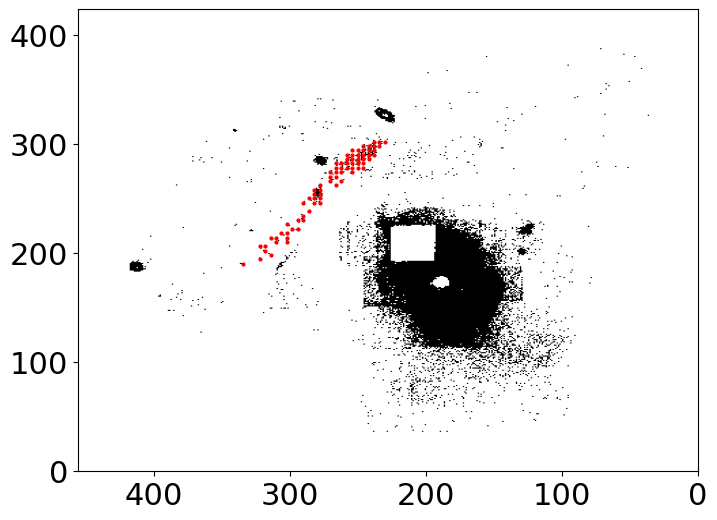

In [143]:
plt.figure(figsize=(8, 6))
#plt.imshow(rebinned_binary , origin='lower', cmap='binary', aspect='auto')
plt.imshow(binary_mask, origin='lower', cmap='binary', aspect='auto')
plt.scatter(x_pts_filtered, y_pts_filtered, color='red', s=4, label="Bin Centers")
#plt.scatter(x_pts, y_pts, color='red', s=4, label="Bin Centers")
plt.gca().invert_xaxis()  # Match FITS convention
plt.show()

## Next steps are to transform the red points to the galactocentric frames youd defined earlier. 

x_pts_filtered, y_pts_filtered are the coordinates you want but you want them first in ra/dec and then in the galactocentric frame of your host galaxy as we discussed reg. astropy

In [147]:
# Convert pixel coordinates to RA/Dec
ra_pts, dec_pts = wcs_helix.all_pix2world(x_pts_filtered, y_pts_filtered, 0)  # 0 = zero-based indexing
print(ra_pts, dec_pts)

[203.35534482 203.1906908  203.08065243 203.13393472 203.13278945
 203.18714491 202.91433354 203.02299557 202.91333161 203.02192344
 203.07621494 202.91233097 202.96659327 202.80286883 202.85710157
 202.91033357 202.74684842 202.80101381 202.74595759 202.6909698
 202.58119938 202.63523255 202.743292   202.5804173  202.63441574
 202.68841192 202.57963622 202.63359998 202.57885615 202.63278526
 202.41638099 202.57807707 202.36183861 202.46957271 202.41503304
 202.46886465 202.25295824 202.36056138 202.41436036 202.4681575
 202.1448492  202.1986202  202.25238972 202.30615769 202.35992399
 202.41368855 202.14435021 202.19808681 202.25182194 202.30555551
 202.35928742 202.41301759 202.09014825 202.14385186 202.1975541
 202.25125487 202.30495409 202.03601428 202.08968484 202.14335414
 202.19702207 202.25068854 202.30435345 202.03558574 202.08922203
 202.14285706 202.19649072 202.25012292 201.98155451 202.03515775
 202.08875981 202.14236061 201.92759112 201.98116125 202.0347303 ] [-42.8218750

## Then convert ra_pts, dec_pts to galactocentric